# MAiWDZD - Tutorial 2 (10.04)
# Użycie narzędzi scikit-learn do wizualizacji małych zbiorów danych - MDS, LLE i Isomap

In [1]:
%matplotlib notebook

In [2]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap
from sklearn import datasets
from sklearn import manifold
from random import randint
from random import uniform
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

In [3]:
def display_hist(variance, number_of_components=None, percentage=False):
    total = sum(variance)
    bar_heights = variance[:number_of_components]
    
    plt.figure()
    plt.xlabel("Components")
    if percentage:
        bar_heights = list(map(lambda x: x * 100 / total, bar_heights))
        plt.ylabel("[%]")

    bar_x_coordinates = np.array(range(len(bar_heights)))
    labels = ['PC ' + str(i) for i in range(1, len(bar_heights) + 1)]
    
    plt.bar(bar_x_coordinates, bar_heights, tick_label=labels)
    plt.show()
    return

In [4]:
def display_scatter_plot_2d(data_x, selector, l1, l2, l3, title=""):
    fig, ax = plt.subplots(ncols=2, figsize=(9,4))
    
    ax[1].scatter(data_x[selector == 1, 0], data_x[selector == 1, 1], c='red', s=10, label=l1)
    ax[1].scatter(data_x[selector == 0, 0], data_x[selector == 0, 1], c='blue', s=10, label=l2)
    ax[0].scatter(zip(*data_x)[0], zip(*data_x)[1], c='black', s=10, label=l3)
    
    fig.suptitle(title)
    plt.legend()
    plt.show()

In [5]:
def sr_display_scatter_plot_2d(data, color, title=""):
    fig, ax = plt.subplots(ncols=2, figsize=(9,4))
    
    ax[1].scatter(data[:, 0], data[:, 1], c=color, cmap=plt.cm.Spectral, s=10)
    ax[0].scatter(data[:, 0], data[:, 1], c='black', s=10)

    plt.title(title)
    plt.show()
    plt.show()

# 1. Zbiór 'sfera w sferze' i metody PCA, MDS, LLE oraz Isomap

Metody z modułu Manifold (scikit-learn): https://scikit-learn.org/stable/modules/manifold.html

In [6]:
# funkcja generująca sferę w sferze
def gen_sphere(dims, points_num, avg_radius, radius_delta, center = None):
    if not center:
        center = np.zeros(dims)
    rad_min_factor = (avg_radius - radius_delta) / float(avg_radius)
    rad_max_factor = (avg_radius + radius_delta) / float(avg_radius)
    vecs = [[(randint(0, 1)*2 - 1) * uniform(0.1, 10) for dim in range(dims)] for p in range(points_num)]
    lengths = [np.sqrt(sum([coord*coord for coord in vec])) for vec in vecs]
    vecs_uni = [[coord * avg_radius / length for coord in vec] for vec,length in zip(vecs,lengths)]
    points = list([np.multiply(vec,uniform(rad_min_factor, rad_max_factor)) + center for vec in vecs_uni])
    #return vecs_uni
    return points

## Zbiór w dwóch wymiarach:

In [7]:
dims = 2
points = 200

inner_2d = zip(*gen_sphere(dims, points, 7, 3))
outer_2d = zip(*gen_sphere(dims, points, 23, 3))

<IPython.core.display.Javascript object>


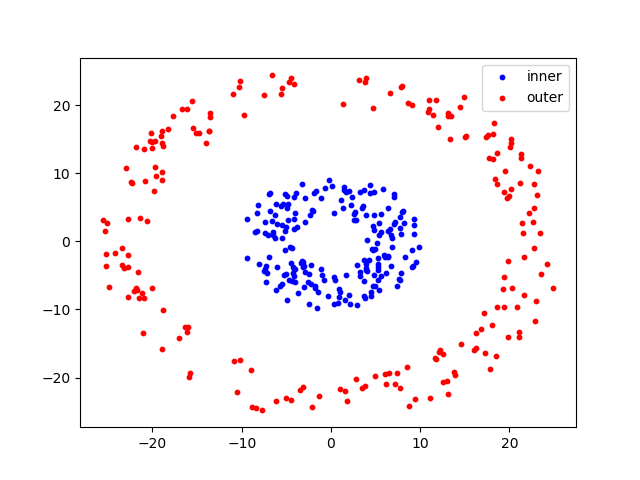

In [8]:
plt.figure()
plt.scatter(inner_2d[0], inner_2d[1], c='blue', s=10, label='inner')
plt.scatter(outer_2d[0], outer_2d[1], c='red', s=10, label='outer')
plt.title("")
plt.legend()
plt.show()

## Zbiór w trzech wymiarach:

In [9]:
dims = 3
points = 200

inner_3d = zip(*gen_sphere(dims, points, 7, 3))
outer_3d = zip(*gen_sphere(dims, points, 23, 3))

<IPython.core.display.Javascript object>


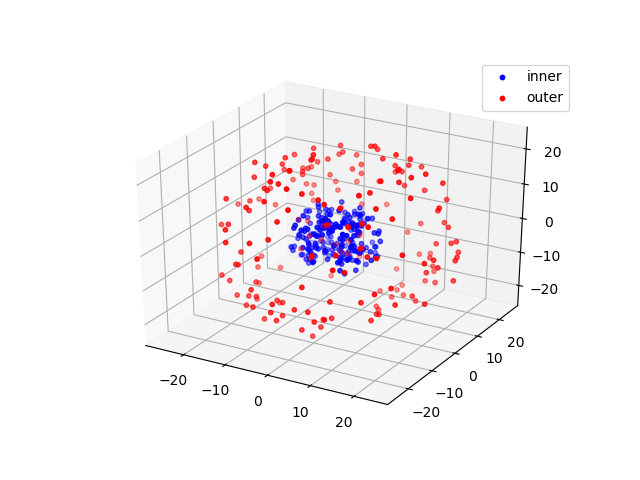

In [10]:
plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(inner_3d[0], inner_3d[1], inner_3d[2], c='blue', s=10, label='inner')
ax.scatter(outer_3d[0], outer_3d[1], outer_3d[2], c='red', s=10, label='outer')
plt.title("")
plt.legend()
plt.show()

# Porównanie działania dla przestrzeni 10-wymiarowej

In [11]:
points = 200
dims = 10

In [12]:
inner = gen_sphere(dims, points, 20, 3)
outer = gen_sphere(dims, points, 40, 3)
data = inner + outer
data = StandardScaler().fit_transform(data)
data_clusters = np.array([0 for i in range(points)] + [1 for i in range(points)])

# 2. Zbiór "Swiss Roll"


In [13]:
sr_points = 800
sr_dims = 3

<IPython.core.display.Javascript object>


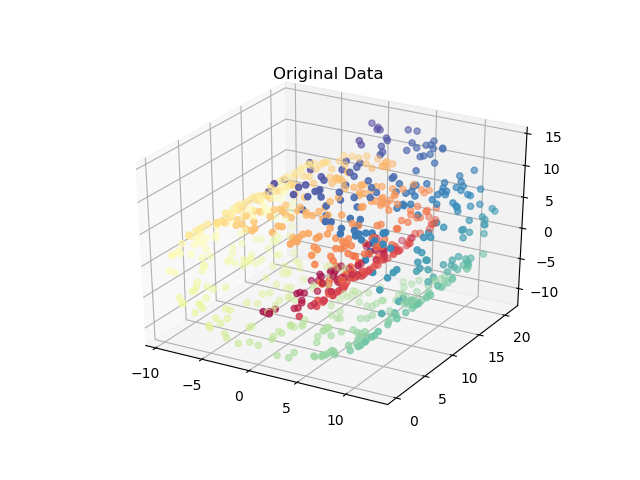

In [14]:
sr_data,sr_color = datasets.make_swiss_roll(n_samples=sr_points, noise=0.0, random_state=None)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sr_data[:, 0], sr_data[:, 1], sr_data[:, 2], c=sr_color, cmap=plt.cm.Spectral)

plt.title('Original Data')
plt.show()

## PCA (Principal component analysis)

<IPython.core.display.Javascript object>


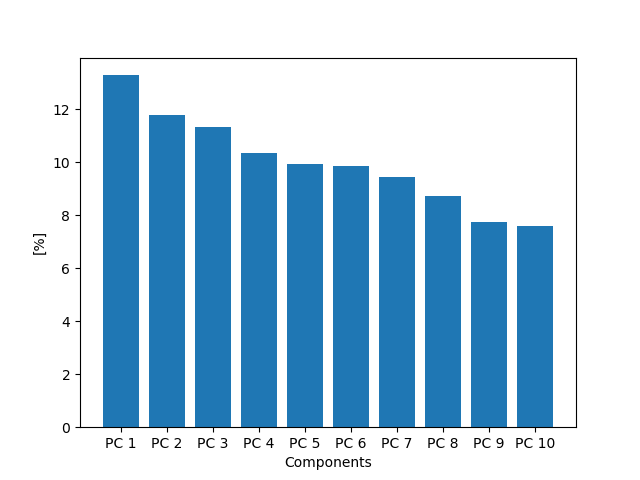

In [15]:
# PCA
embedding_pca = PCA(n_components = dims)
pca_x = embedding_pca.fit_transform(data)
#pca_x.shape

# histogram
display_hist(embedding_pca.explained_variance_, dims, True)

<IPython.core.display.Javascript object>


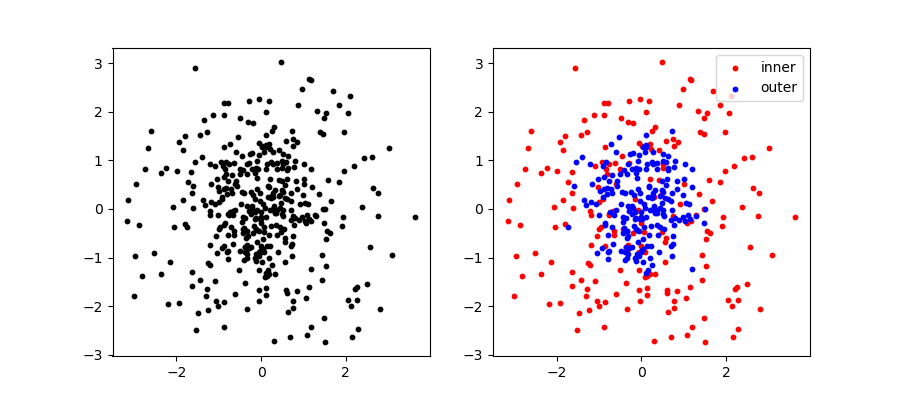

In [37]:
# wykres 2D
display_scatter_plot_2d(pca_x, data_clusters,'inner','outer','all')

<IPython.core.display.Javascript object>


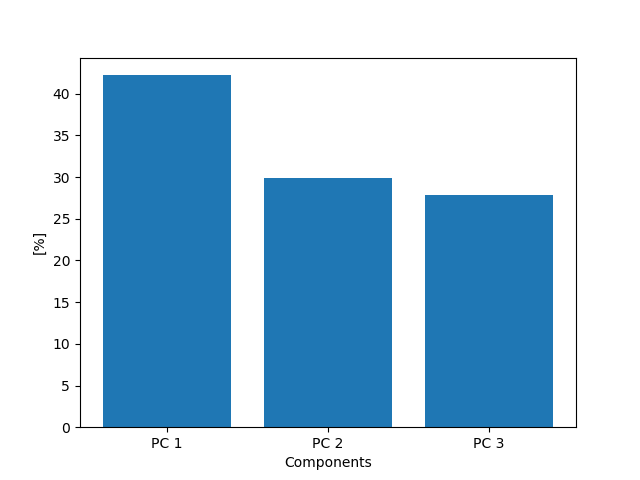

In [16]:
# PCA
sr_embedding_pca = PCA(n_components = sr_dims)
sr_pca_x = sr_embedding_pca.fit_transform(sr_data)
#pca_x.shape

# histogram
display_hist(sr_embedding_pca.explained_variance_, sr_dims, True)

<IPython.core.display.Javascript object>


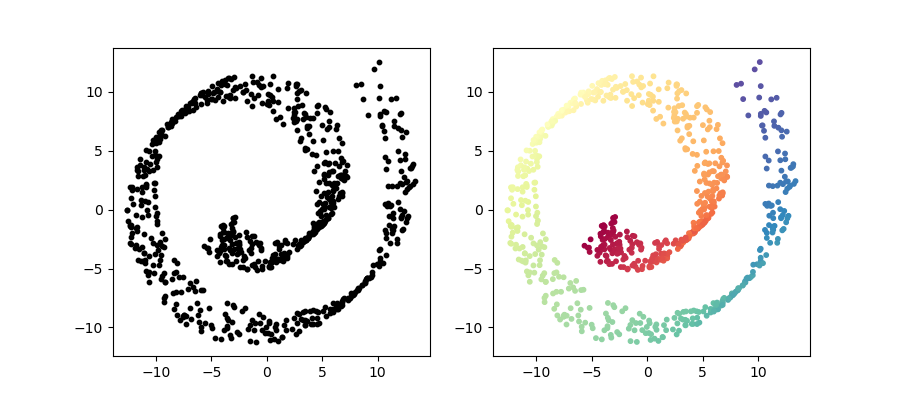

In [39]:
sr_display_scatter_plot_2d(sr_pca_x,sr_color)

## MDS (Multi-dimensional Scaling)

Dąży do takiego rozmieszczenia obiektów w nowej przestrzeni, aby obiekty podobne do siebie znajdowały się bliżej. Metoda ta działa na podstawie macierzy odległości lub podobieństwa pomiędzy obiektami (np. macierz korelacji) 

In [17]:
# MDS
embedding_mds = MDS()
mds_x = embedding_mds.fit_transform(data)
mds_x.shape

(400, 2)

<IPython.core.display.Javascript object>


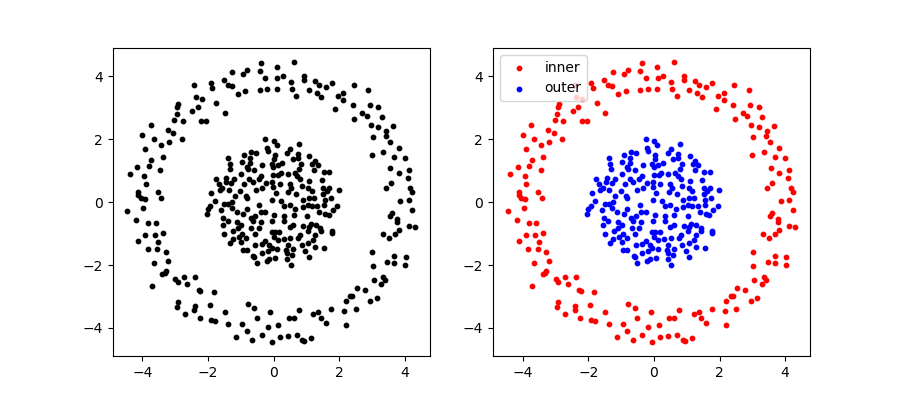

In [18]:
# wykres 2D
display_scatter_plot_2d(mds_x, data_clusters,'inner','outer','all')

In [19]:
# MDS
sr_embedding_mds = MDS()
sr_mds_x = sr_embedding_mds.fit_transform(sr_data)
sr_mds_x.shape

(800, 2)

In [20]:
# wykres 2D
sr_display_scatter_plot_2d(sr_mds_x,sr_color)

<IPython.core.display.Javascript object>

#### Przydatne linki:
- https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html
- https://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling

## Isomap

Metoda ta otrzymuje na wejsciu odległości między punktami i jego najbliższymi sąsiadami.
Następnie przy pomocy algorytmu Floyda-Warshalla obliczane są odległości między wszystkimi punktami.
Następnie Isomap używa klasycznego MDS do obliczenia pozycji. 

In [21]:
# Isomap
embedding_isomap = Isomap()
isomap_x = embedding_isomap.fit_transform(data)
isomap_x.shape

(400, 2)

In [22]:
# wykres 2D
display_scatter_plot_2d(isomap_x, data_clusters,'inner','outer','all')

<IPython.core.display.Javascript object>

In [24]:
# Isomap
sr_embedding_isomap = Isomap()
sr_isomap_x = sr_embedding_isomap.fit_transform(sr_data)
sr_isomap_x.shape

(800, 2)

<IPython.core.display.Javascript object>


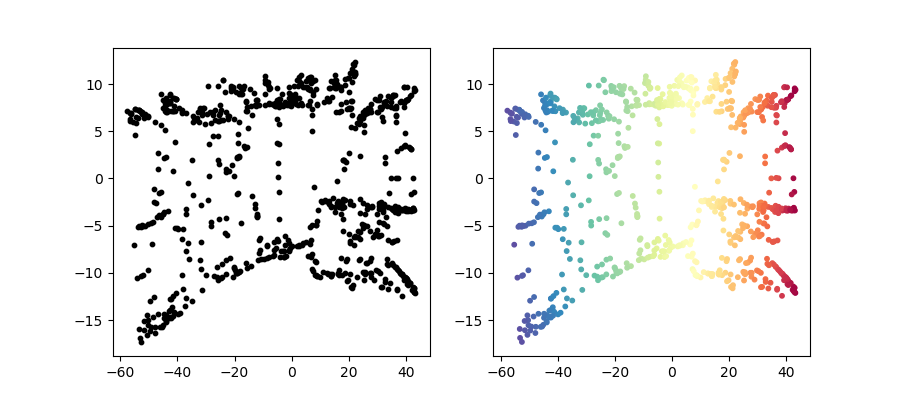

In [25]:
# wykres 2D
sr_display_scatter_plot_2d(sr_isomap_x,sr_color)

#### Przydatne linki:
- https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html#sklearn.manifold.Isomap
- https://scikit-learn.org/stable/modules/manifold.html#isomap

## LLE (Locally Linear Embedding)

Ta metoda również wykorzystuje najbliższych sąsiadów. Każdy punkt jest przedstawiany jako liniowa kominacja jego sąsiadów. LLE stara się tak umieścić punkty w nowej przestrzeni, aby każdy punkt nadal był opisywany tą samą kombinacją liniową sąsiadów.

In [26]:
# LLE
lle_x, err = manifold.locally_linear_embedding(data, n_neighbors=12, n_components=2)

<IPython.core.display.Javascript object>


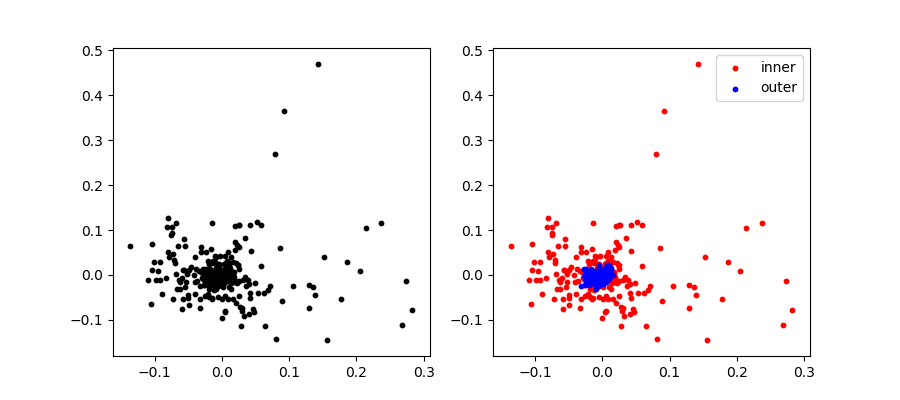

In [27]:
# LLE
display_scatter_plot_2d(lle_x, data_clusters,'inner','outer','all')

In [28]:
# LLE
sr_lle_x, err = manifold.locally_linear_embedding(sr_data, n_neighbors=12, n_components=2)

<IPython.core.display.Javascript object>


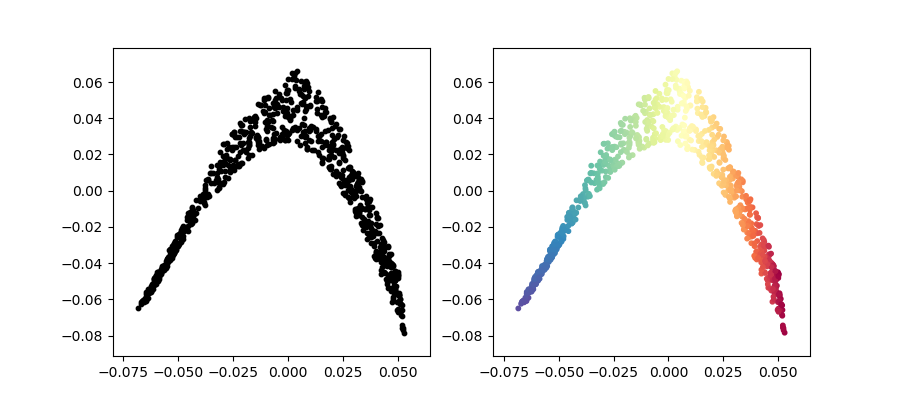

In [29]:
sr_display_scatter_plot_2d(sr_lle_x, sr_color)

#### Przydatne linki:
- https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html#sklearn.manifold.LocallyLinearEmbedding
- https://scikit-learn.org/stable/modules/manifold.html#locally-linear-embedding

# 2. Metryka

In [30]:
def nn(data, tag, k): 
    k = k+1
    n = NearestNeighbors(k, algorithm='kd_tree').fit(data)
    distances, indices = n.kneighbors(data)
    indexes = indices[:,0]
    indices = indices[:,1:]

    neighbour_stats = []
    for index, neighbours in zip(indexes,indices):
        same_cluster_neighbours = filter(
            lambda neighbour: tag[neighbour] == tag[index],
            neighbours
        )
        neighbour_stats.append(len(list(same_cluster_neighbours)) / float(k-1))
        
    return neighbour_stats

In [37]:
k = 10

stats = nn(data, data_clusters, k)
print('orginal data:', round(np.mean(stats), 3))

stats = nn(pca_x, data_clusters, k)
print('pca: ', round(np.mean(stats), 3))

stats = nn(mds_x, data_clusters, k)
print('mds: ', round(np.mean(stats), 3))

stats = nn(lle_x, data_clusters, k)
print('lle: ', round(np.mean(stats), 3))

stats = nn(isomap_x, data_clusters, k)
print('isomap: ', round(np.mean(stats), 3))

('orginal data:', 0.655)
('pca: ', 0.655)
('mds: ', 1.0)
('lle: ', 0.82)
('isomap: ', 0.529)


## KNN
<b>Czy punkt będący jednym z najbliższych sąsiadów w oryginalnej przestrzeni, będzie nim również w nowej przestrzeni?</b>

In [43]:
def knn(data, data_mapping, k):
    k = k+1
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='kd_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)
    indices = indices[:,1:]
    
    nbrs_mapping = NearestNeighbors(n_neighbors=k, algorithm='kd_tree').fit(data_mapping)
    distances_mapping, indices_mapping = nbrs_mapping.kneighbors(data_mapping)
    indices_mapping = indices_mapping[:,1:]

    neighbour_stats = []
    for n, n_mapping in zip(indices,indices_mapping):
        neighbour_stats.append(len(np.intersect1d(n, n_mapping)) / float(k-1))
        
    return neighbour_stats   

In [55]:
k = 50

stats = knn(data, data, k)
print('orginal data:', round(np.mean(stats), 3))

stats = knn(data, pca_x, k)
print('pca: ', round(np.mean(stats), 3))

stats = knn(data, mds_x, k)
print('mds: ', round(np.mean(stats), 3))

stats = knn(data, lle_x, k)
print('lle: ', round(np.mean(stats), 3))

stats = knn(data, isomap_x, k)
print('isomap: ', round(np.mean(stats), 3))

('orginal data:', 1.0)
('pca: ', 1.0)
('mds: ', 0.314)
('lle: ', 0.242)
('isomap: ', 0.27)


# 3. Diagram Sheparda - diagram odległości

In [ ]:
# returns list of distances between pair of points from set
def distances(vecs):
    coords = [tuple(vec) for vec in vecs]
    dists = cdist(coords, coords, 'euclidean')
    return list(zip(*dists)[0])

In [ ]:
def display_shepard_diagram(input_data,output_data,title):
    fig, ax = plt.subplots(ncols=1)
    dist_x = distances(input_data)
    dist_y = distances(output_data)
    
    ax.scatter(dist_x, dist_y, c='green', s=10)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, c='grey')
    
    plt.xlabel("Input")
    plt.ylabel("Output")
    
    plt.title("Shepard diagram: "+title)
    plt.legend()
    plt.show()

## Idealny przypadek (dla wejściowego zbioru 2d)

In [ ]:
data_2d = gen_sphere(2, points, 20, 3) + gen_sphere(2, points, 40, 3)
mds_x_2d = embedding_mds.fit_transform(data_2d)

display_shepard_diagram(data_2d, mds_x_2d, '')

## MDS

In [ ]:
display_shepard_diagram(data, mds_x, 'MDS')

## LLE

In [ ]:
display_shepard_diagram(data, lle_x, 'LLE')

## Isomap

<IPython.core.display.Javascript object>


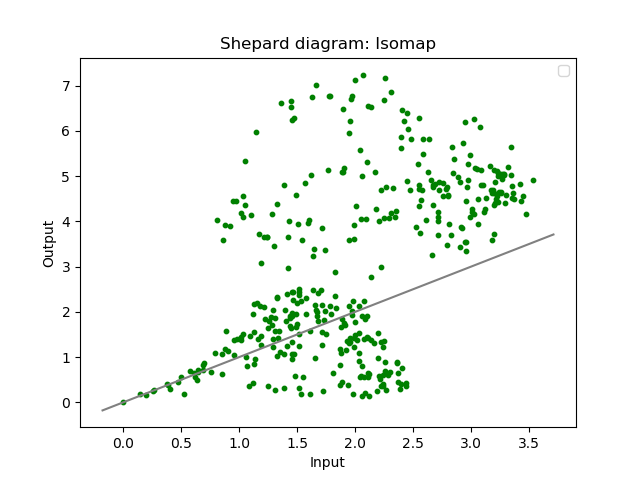

In [46]:
display_shepard_diagram(data, isomap_x, 'Isomap')

# Zadania

- Metody MDS, LLE oraz Isomap przyjmują różne parametry. Dotychczas zaprezentowano ich wersje domyślne. W ramach zadania należy zbadać wyniki MDS, LLE oraz Isomap dla zmienionych parametrów. 

- Porównanie wartości metryk nearest neighbours (NN) oraz k-nearest neighbours (kNN) dla różnych metod na zbiorze smallNORB. Uzupełnić tabelę (zapis NN-1 oznacza NN dla k=1):

| Metoda/Metryka | NN-1 | NN-10 | kNN-1 | kNN-3
| --- | --- | --- | --- | --- |
| PCA | ? | ? | ? | ? |
| MDS | ? | ? | ? | ? |
| LLE | ? | ? | ? | ? |
| Isomap | ? | ? | ? | ? |

In [47]:
# pobranie danych
def get_data(group_number, smallnorb_path = '../smallnorb.csv'):
    smallnorb = pandas.read_csv(smallnorb_path, sep=',', skiprows = (group_number-1)*1000, nrows=1000, header=None)
    smallnorb = StandardScaler().fit_transform(smallnorb)
    smallnorb.shape
    return smallnorb

In [99]:
smallnorb = get_data(1)

array([[-0.6492184 , -0.41915425, -0.86484151, ..., -0.2287189 ,
        -0.9887181 , -1.41421356],
       [-0.54913026,  0.23360085, -0.61253872, ...,  0.15234808,
         0.8724797 , -0.70710678],
       [-0.27280248, -0.15437078, -0.0432025 , ..., -1.38002523,
        -0.09020718,  0.        ],
       ...,
       [ 1.13898254, -1.16642202, -0.27186804, ...,  0.46191584,
        -1.03832666,  0.        ],
       [-0.11286155,  0.72240181, -1.31053452, ...,  0.0183354 ,
         0.65585897,  0.70710678],
       [-0.69052445, -0.20093061,  1.86442128, ...,  0.30063096,
         0.913572  ,  1.41421356]])

Uwaga: po wykonaniu MDS, LLE i Isomap otrzymujemy listę punktów: $smallnorb = [[x1,y1],[x2,y2],[x3,y3]...]$ <br>
Do wykresu potrzebujemy natomiast dane w postaci $[x1,x2,x3...]$, $[y1,y2,y3...]$.<br>
Funkcja $coords$ dokonuje takiego przekształcenia i zwraca krotkę $([x1,x2,x3...]$, $[y1,y2,y3...])$.

In [80]:
def coords(pointsList):
    return zip(*pointsList)

In [81]:
coords([[1,2],[3,4]])[0]

(1, 3)

<IPython.core.display.Javascript object>


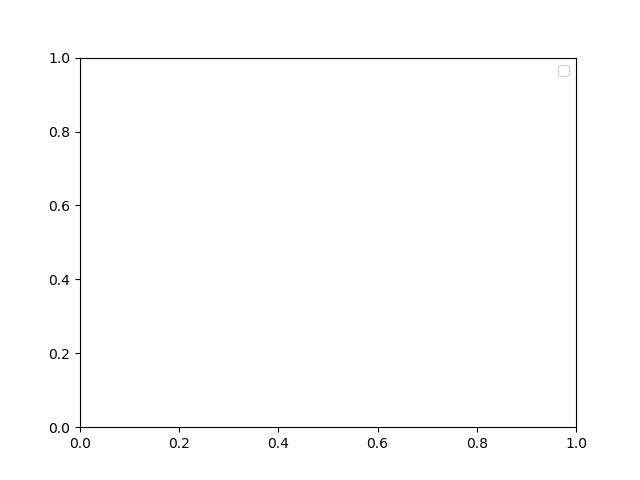

In [82]:
#x = <funkcja>.fit_transform(smallnorb)
plt.figure()

#plt.scatter(<x coords>, <y coords>, c='black', s=10)

plt.title("")
plt.legend()
plt.show()

- Zbadać działanie przedstawionych metod na poniższym zbiorze

In [59]:
points_ex = 200
dims_ex = 3

bl = gen_sphere(dims_ex, points_ex, 0.5, 0.4, [-1, -1, -1])
tr = gen_sphere(dims_ex, points_ex, 0.5, 0.4, [1, 1, 1])
data_clusters_ex = np.array([0 for i in range(points_ex)] + [1 for i in range(points_ex)])

In [62]:
def plot_axes(ax):
    x = np.linspace(*ax.get_xlim())
    o = np.zeros(len(x))
    #ax.plot(x,x,x, c='grey')
    ax.plot(x,o,o, c='grey')
    ax.plot(o,x,o, c='grey')
    ax.plot(o,o,x, c='grey')

<IPython.core.display.Javascript object>


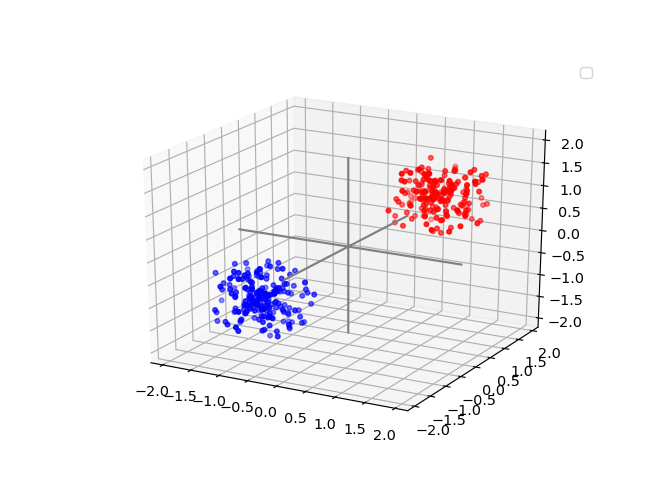

In [65]:
plt.figure()
ax = plt.subplot(111, projection='3d')

ax.scatter(zip(*bl)[0], zip(*bl)[1], zip(*bl)[2], c='blue', s=10)
ax.scatter(zip(*tr)[0], zip(*tr)[1], zip(*tr)[2], c='red', s=10)
plot_axes(ax)

plt.title("")
plt.legend()
plt.show()

In [32]:
data_ex = []
extra_dims = 50

for point in bottom_left + top_right:
    data_ex.append(np.concatenate((point,[uniform(-2,2) for i in range(extra_dims)])))

data_ex = StandardScaler().fit_transform(data_ex)
data_ex.shape

(400, 53)

## Dla zainteresowanych

Sprawdzić działanie metod PCA, MDS, LLE oraz Isomap (wizualizacja oraz diagram Sheparda) dla następującego zbioru:

In [33]:
# funkcja generująca punkty
def gen_planes(edge_len, bottom_z = 0, angle = np.pi / 4):
    bottom_plane = [[i, j, bottom_z] for i in range(edge_len) for j in range(edge_len)]
    upper_plane = [[j, i * np.cos(angle), i * np.sin(angle)] for i in range(edge_len) for j in range(edge_len)]
    return bottom_plane, upper_plane

Parametry do modyfikacji:

In [34]:
bottom_z = -1
angle = np.pi / 3

In [35]:
edge_len = 10
points = edge_len ** 2
dims = 3
bottom_plane, upper_plane = gen_planes(edge_len,bottom_z,angle)
data = bottom_plane + upper_plane
data = StandardScaler().fit_transform(data)
data_clusters = np.array([0 for i in range(points)] + [1 for i in range(points)])

<IPython.core.display.Javascript object>


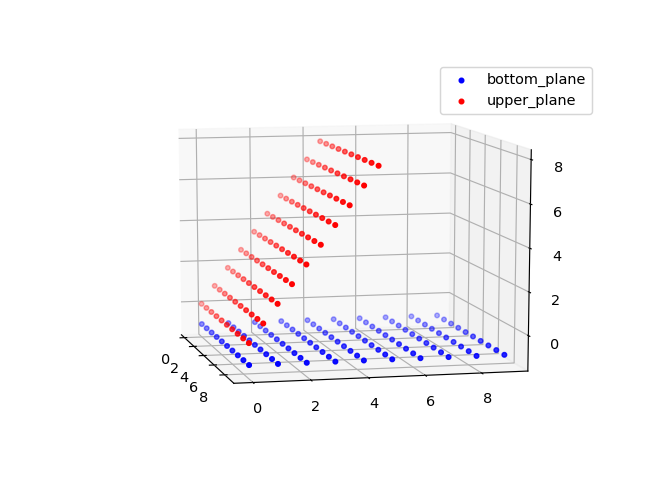

In [36]:
plt.figure()
ax = plt.subplot(111, projection='3d')

ax.scatter(zip(*bottom_plane)[0], zip(*bottom_plane)[1], zip(*bottom_plane)[2], c='blue', s=10, label='bottom_plane')
ax.scatter(zip(*upper_plane)[0], zip(*upper_plane)[1], zip(*upper_plane)[2], c='red', s=10, label='upper_plane')

plt.title("")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


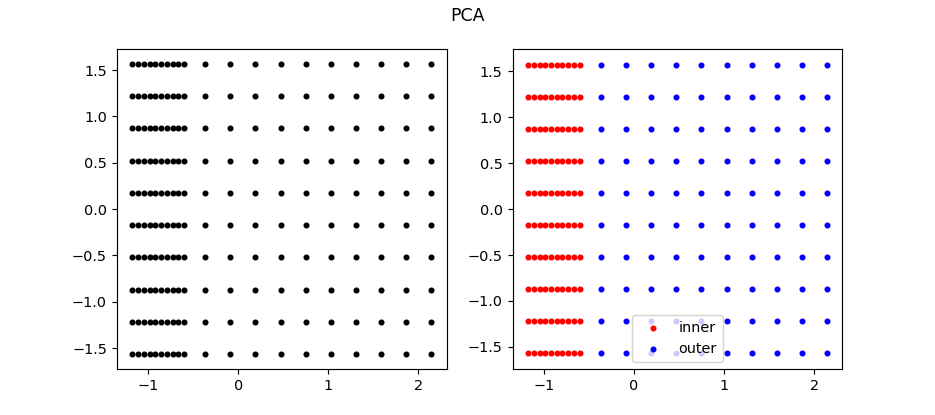

<IPython.core.display.Javascript object>


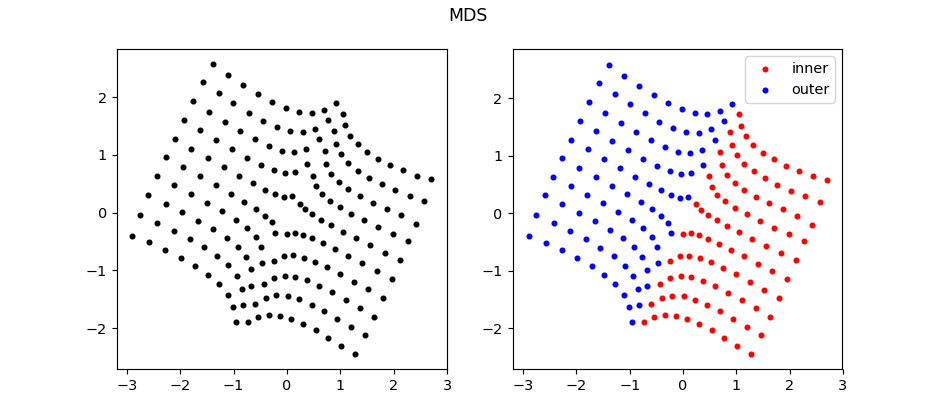

<IPython.core.display.Javascript object>


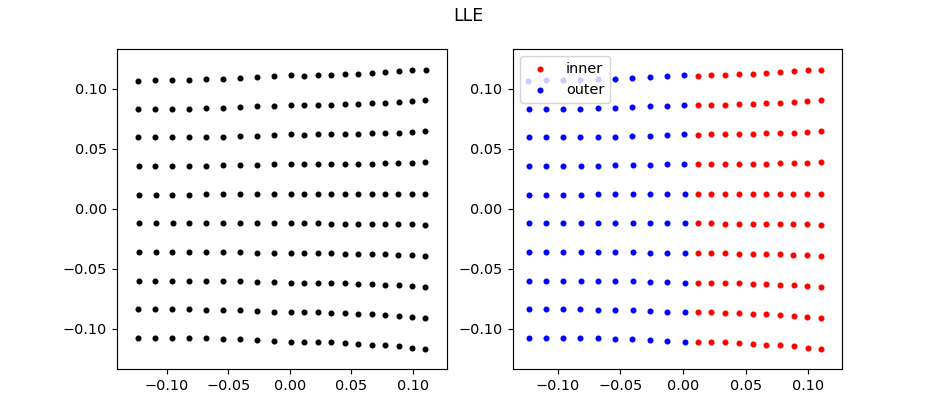

<IPython.core.display.Javascript object>


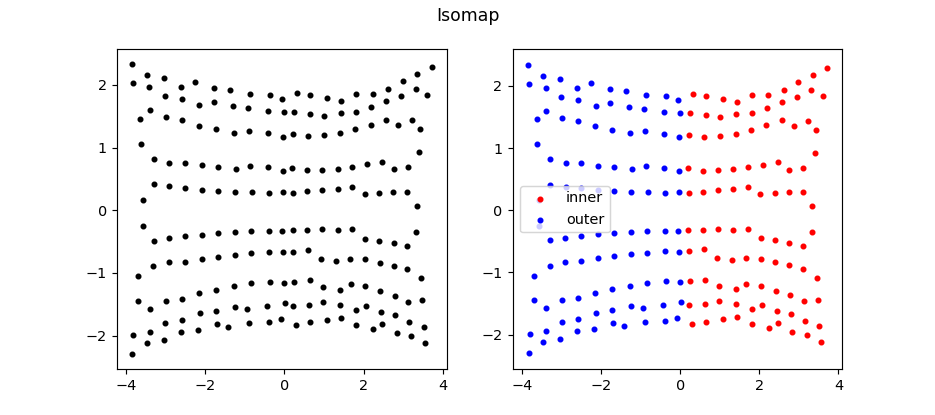

In [37]:
# PCA
embedding_pca = PCA(n_components = dims)
pca_x = embedding_pca.fit_transform(data)
#display_hist(embedding_pca.explained_variance_, dims, True)
display_scatter_plot_2d(pca_x, data_clusters,'inner','outer','all','PCA')

# MDS
mds_x = MDS().fit_transform(data)
display_scatter_plot_2d(mds_x, data_clusters,'inner','outer','all','MDS')

# LLE
lle_x = LocallyLinearEmbedding().fit_transform(data)
display_scatter_plot_2d(lle_x, data_clusters,'inner','outer','all','LLE')

# Isomap
isomap_x = Isomap().fit_transform(data)
display_scatter_plot_2d(isomap_x, data_clusters,'inner','outer','all','Isomap')

<IPython.core.display.Javascript object>


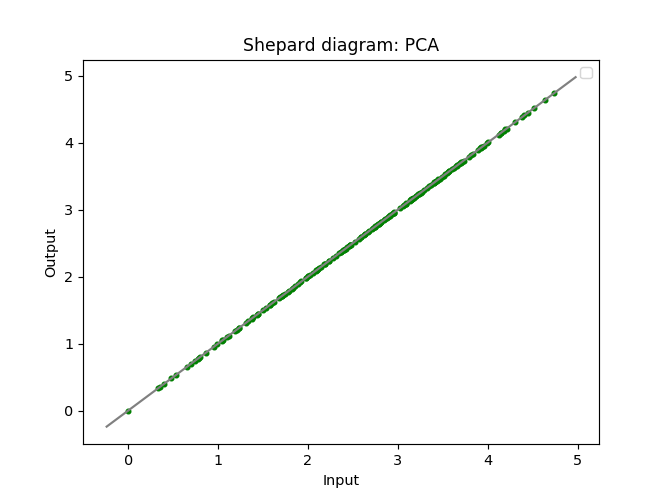

<IPython.core.display.Javascript object>


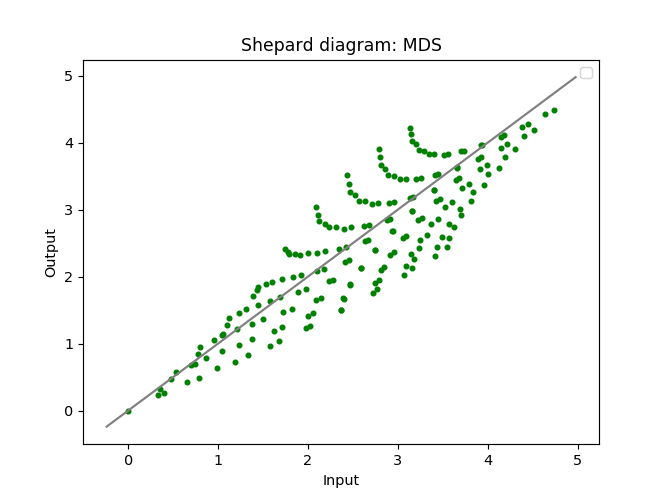

<IPython.core.display.Javascript object>


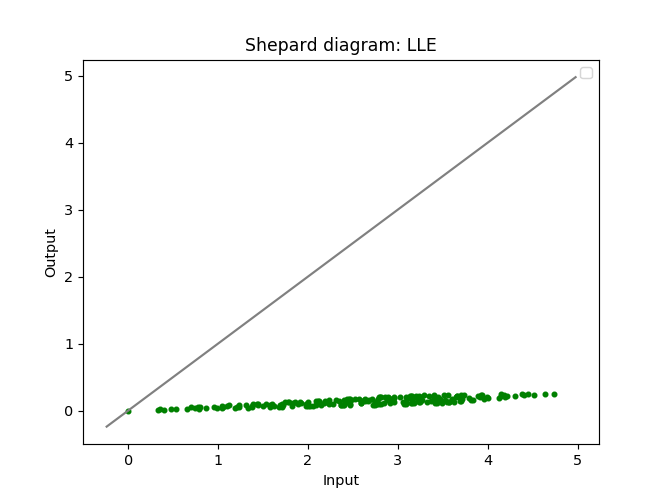

<IPython.core.display.Javascript object>


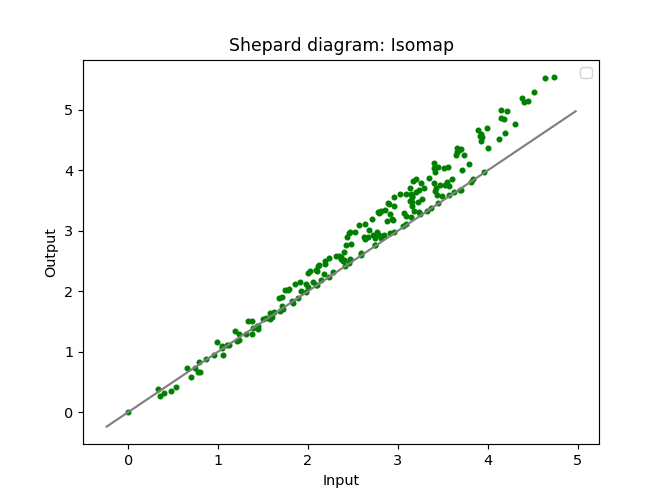

In [39]:
display_shepard_diagram(data, pca_x, 'PCA')
display_shepard_diagram(data, mds_x, 'MDS')
display_shepard_diagram(data, lle_x, 'LLE')
display_shepard_diagram(data, isomap_x, 'Isomap')